# Prerequisite

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np

import sklearn.preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn_pandas import DataFrameMapper

import glob2

In [4]:
mapper = DataFrameMapper([
        (['uac_mean1_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_mean1_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_mean1_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_mean2_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_mean2_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_mean2_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_std1_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_std1_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_std1_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_std2_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_std2_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_std2_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean1_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean1_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean1_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean2_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean2_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_mean2_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std1_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std1_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std1_z'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std2_x'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std2_y'], sklearn.preprocessing.StandardScaler()),
        (['uac_dev_std2_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean1_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean1_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean1_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean2_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean2_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_mean2_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std1_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std1_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std1_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std2_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std2_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_std2_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean1_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean1_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean1_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean2_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean2_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_mean2_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std1_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std1_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std1_z'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std2_x'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std2_y'], sklearn.preprocessing.StandardScaler()),
        (['gyr_dev_std2_z'], sklearn.preprocessing.StandardScaler()),
        ('label', sklearn.preprocessing.LabelBinarizer())
    ])

In [5]:
def import_labelled_data(data_folder="data/LabelledData"):
    df_list = []

    for data_file in glob2.glob("{}/*.csv".format(data_folder)):
        df_list.append(pd.read_csv(data_file).iloc[:,1:])

    df = pd.concat(df_list, ignore_index=True)
    
    for sensor in ['uac', 'gyr']:
        for axis in ['x', 'y', 'z', 'amp']:
#             df[f'{sensor}_relative_gap_{axis}'] = df[f'{sensor}_gap_{axis}'] / df['touch_duration']
            df[f'{sensor}_diff_{axis}'] = df[f'{sensor}_max_{axis}'] - df[f'{sensor}_min_{axis}']
            df[f'{sensor}_dev_diff_{axis}'] = df[f'{sensor}_dev_max_{axis}'] - df[f'{sensor}_dev_min_{axis}']
    
    return df


def print_evaluation_result(clf, X, y, cv=10):
    metrics = ['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted', 'recall']
#     metrics = ['balanced_accuracy', 'f1', 'f1_weighted', 'recall']
    
    for scoring in metrics:
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring, error_score='raise')
        
        print("Scoring Metric: {}\n---------".format(scoring))
        print("Scores: {}".format(scores))
        print("{}: {:.2f} (+/- {:.2f})\n".format(scoring, scores.mean(), scores.std() * 2))

        
def get_processd_data(df):
    data = mapper.fit_transform(df.copy())
    X = data[:, :-1]
    y = 1 - data[:, -1]  # Flip 0 and 1 so Bot is with positive label
    
    return X, y


def get_processed_posture_data(df):
    rest_df = df[df['remark'].str.contains('Desk') | df['remark'].str.contains('Stand')]
    rest_df = rest_df.assign(label="Rest")
    handheld_df = df[df['remark'].str.contains('Handheld')]
    handheld_df = handheld_df.assign(label="Handheld")

    posture_df = pd.concat([rest_df, handheld_df])
    posture_df.reset_index(drop=True, inplace=True)
    
    return get_processd_data(posture_df)



In [4]:
df = import_labelled_data()

## Get Processed Bot Detection Data

In [7]:
X, y = get_processd_data(df)


# ML Models

## Decision Tree

In [86]:
from sklearn.tree import DecisionTreeClassifier

for max_depth in range(7, 15):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    scores = cross_val_score(clf, X, y, cv=10, scoring='balanced_accuracy')
    
    print("Max Depth: {}\n-----------".format(max_depth))
    print("Scores: {}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))


Max Depth: 7
-----------
Scores: [0.81492734 0.92562984 0.9426859  0.91349053 0.88374785 0.94238085
 0.93381965 0.97240215 0.96750001 0.94426153]
Accuracy: 0.92 (+/- 0.09)

Max Depth: 8
-----------
Scores: [0.83107721 0.92595733 0.93335935 0.91542851 0.9003553  0.95407605
 0.94235323 0.97971018 0.97396832 0.95354374]
Accuracy: 0.93 (+/- 0.08)

Max Depth: 9
-----------
Scores: [0.83908949 0.92220697 0.93921368 0.9223909  0.90482791 0.95343005
 0.94743678 0.98061804 0.97462663 0.95807156]
Accuracy: 0.93 (+/- 0.08)

Max Depth: 10
-----------
Scores: [0.84574226 0.92576443 0.93410404 0.87847671 0.91011251 0.96750736
 0.93885804 0.97971018 0.97488765 0.95792382]
Accuracy: 0.93 (+/- 0.08)

Max Depth: 11
-----------
Scores: [0.8337287  0.92124246 0.94640935 0.91620909 0.90404734 0.97603987
 0.9394934  0.97796259 0.95860359 0.95778757]
Accuracy: 0.93 (+/- 0.08)



KeyboardInterrupt: 

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=9, random_state=0)
print_evaluation_result(clf, X, y)


Scoring Metric: accuracy
---------
Scores: [0.8960499  0.93939394 0.91622103 0.90849673 0.85888295 0.98425431
 0.97384844 0.94175334 0.97711738 0.94086181]
accuracy: 0.93 (+/- 0.08)

Scoring Metric: balanced_accuracy
---------
Scores: [0.77616765 0.9076362  0.92521264 0.88485591 0.89659148 0.96984012
 0.94943392 0.92814666 0.96698943 0.94481727]
balanced_accuracy: 0.91 (+/- 0.11)

Scoring Metric: f1
---------
Scores: [0.93666305 0.96087457 0.94350962 0.93986724 0.90023104 0.9898448
 0.98321892 0.96185286 0.9851552  0.96066416]
f1: 0.96 (+/- 0.05)

Scoring Metric: f1_weighted
---------
Scores: [0.88461904 0.93896942 0.91923219 0.90970479 0.86775674 0.98412498
 0.97347009 0.94233411 0.97710176 0.94234314]
f1_weighted: 0.93 (+/- 0.07)

Scoring Metric: recall
---------
Scores: [0.99807173 0.96643519 0.90856481 0.92862654 0.82677469 0.99652778
 0.99459877 0.9533179  0.98572531 0.9375    ]
recall: 0.95 (+/- 0.10)



## Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

for max_depth in range(3, 15):
    clf = RandomForestClassifier(n_estimators=max_depth, max_depth=10, random_state=0)
    scores = cross_val_score(clf, X, y, cv=10, scoring='balanced_accuracy')
    
    print("Max Depth: {}\n-----------".format(max_depth))
    print("Scores: {}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))


Max Depth: 3
-----------
Scores: [0.84476841 0.941044   0.935405   0.91065533 0.90102372 0.97099752
 0.95985134 0.96417477 0.97429747 0.96135088]
Accuracy: 0.94 (+/- 0.08)

Max Depth: 4
-----------
Scores: [0.85232752 0.9364368  0.92628481 0.92447692 0.90313666 0.97151791
 0.96069107 0.96304032 0.97720247 0.96606011]
Accuracy: 0.94 (+/- 0.07)

Max Depth: 5
-----------
Scores: [0.84199161 0.93042097 0.93848245 0.93154698 0.90810275 0.97616548
 0.96300589 0.96807871 0.98225234 0.97192676]
Accuracy: 0.94 (+/- 0.08)

Max Depth: 6
-----------
Scores: [0.8426376  0.93829852 0.93842413 0.92151611 0.90707992 0.97958836
 0.95957883 0.96912283 0.98302394 0.97297087]
Accuracy: 0.94 (+/- 0.08)

Max Depth: 7
-----------
Scores: [0.85103553 0.93849142 0.93874264 0.93044789 0.90739844 0.97958836
 0.96229093 0.97616983 0.98360265 0.97367435]
Accuracy: 0.94 (+/- 0.08)

Max Depth: 8
-----------
Scores: [0.85297352 0.94488408 0.94274422 0.92993648 0.90778424 0.97765037
 0.96358459 0.97577255 0.98444238 0

KeyboardInterrupt: 

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=8, max_depth=10, random_state=0)
print_evaluation_result(clf, X, y)

Scoring Metric: accuracy
---------
Scores: [0.89486189 0.95454545 0.81431967 0.92335116 0.84551396 0.9869281
 0.97682021 0.96433878 0.98276374 0.96047548]
accuracy: 0.93 (+/- 0.11)

Scoring Metric: balanced_accuracy
---------
Scores: [0.771771   0.92834841 0.68460648 0.90356284 0.89606661 0.97429479
 0.95000115 0.96641148 0.97791743 0.96844305]
balanced_accuracy: 0.90 (+/- 0.19)

Scoring Metric: f1
---------
Scores: [0.93607801 0.9706728  0.88466507 0.9497272  0.88888889 0.99156442
 0.9851711  0.97651663 0.9887901  0.97380343]
f1: 0.95 (+/- 0.08)

Scoring Metric: f1_weighted
---------
Scores: [0.8827314  0.95419417 0.80172929 0.92420838 0.85616745 0.98683024
 0.97638846 0.96489505 0.98280247 0.96133821]
f1_weighted: 0.93 (+/- 0.12)

Scoring Metric: recall
---------
Scores: [0.99961435 0.97685185 0.92476852 0.94020062 0.80246914 0.99768519
 0.9996142  0.96257716 0.98688272 0.9537037 ]
recall: 0.95 (+/- 0.11)



## SVM

In [11]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, C=1, loss='hinge')
# clf = LinearSVC(random_state=0, C=1)

print_evaluation_result(clf, X, y)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scoring Metric: accuracy
---------
Scores: [0.93644194 0.86987522 0.83541295 0.84254308 0.82560903 0.89215686
 0.92035661 0.93164933 0.9679049  0.93402675]
accuracy: 0.90 (+/- 0.09)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scoring Metric: balanced_accuracy
---------
Scores: [0.86175711 0.73789657 0.68153801 0.80442506 0.84508236 0.77864359
 0.83618193 0.91568694 0.93831303 0.91632229]
balanced_accuracy: 0.83 (+/- 0.16)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scoring Metric: f1
---------
Scores: [0.96037037 0.92079566 0.90043134 0.89538097 0.87722234 0.93386774
 0.95046211 0.95516569 0.97945205 0.95682614]
f1: 0.93 (+/- 0.06)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scoring Metric: f1_weighted
---------
Scores: [0.93260334 0.85521759 0.81425971 0.8462855  0.83627031 0.8819221
 0.91520219 0.93244301 0.96734086 0.93462975]
f1_weighted: 0.89 (+/- 0.10)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Scoring Metric: recall
---------
Scores: [1.         0.98225309 0.96643519 0.875      0.80902778 0.98881173
 0.99189815 0.94521605 0.99305556 0.94907407]
recall: 0.95 (+/- 0.12)



/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [159]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1, random_state=0)

print_evaluation_result(clf, X, y)


Scoring Metric: accuracy
---------
Scores: [0.91091782 0.89615846 0.88865546 0.79711885 0.85654262 0.92316927
 0.91356543 0.88085234 0.96428571 0.94267707]
accuracy: 0.90 (+/- 0.09)

Scoring Metric: balanced_accuracy
---------
Scores: [0.79959514 0.78311332 0.77780802 0.74214631 0.87882674 0.85164852
 0.82761303 0.86210586 0.92828453 0.91246455]
balanced_accuracy: 0.84 (+/- 0.12)

Scoring Metric: f1
---------
Scores: [0.94583257 0.93663004 0.93176384 0.86576648 0.90095317 0.95204196
 0.9464684  0.92124578 0.97740649 0.96329041]
f1: 0.93 (+/- 0.06)

Scoring Metric: f1_weighted
---------
Scores: [0.90216703 0.88688093 0.87976677 0.80335954 0.86519277 0.91981603
 0.90854285 0.88441134 0.96350617 0.942409  ]
f1_weighted: 0.90 (+/- 0.08)

Scoring Metric: recall
---------
Scores: [1.         0.98649691 0.97723765 0.84104938 0.83873457 0.98032407
 0.98225309 0.89583333 0.99305556 0.96682099]
recall: 0.95 (+/- 0.12)



### For ZKP

In [15]:
def print_integer_scalar():
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        scalar = sklearn.preprocessing.StandardScaler()

        if k == 'touch_duration':
            scalar.fit(np.array(df['touch_duration']).reshape(-1, 1))
            print(f"\"duration\" to Pair({int(round(scalar.mean_[0]))}, {int(round(scalar.scale_[0]))})")
        else:  
            scalar.fit(np.array(df[k]).reshape(-1, 1))
            print(f"\"{k}\" to Pair({int(round(scalar.mean_[0]))}, {int(round(scalar.scale_[0]))}),")
            
        
def get_integer_scaler():
    avgs = []
    stds = []
    
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        scalar = sklearn.preprocessing.StandardScaler()
        
        scalar.fit(np.array(df[k]).reshape(-1, 1))
        avgs.append(int(round(scalar.mean_[0])))
        stds.append(int(round(scalar.scale_[0])))
    
    return avgs, stds
     

In [16]:
avgs, stds = get_integer_scaler()

In [135]:
features = []

for c in list(mapper.transformed_names_[:-1]):
#     print(c)
    features.append(int(round(df.loc[0,c])))

# features = [f + 32000000000 if f < 0 else f for f in features]
features = [f + 3200000000000 for f in features]

### For Android App

In [8]:
def print_coef(coef):
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        if k == 'touch_duration':
            print(f"\"duration\" to {coef[0][i]}f")
        else:
            print(f"\"{k}\" to {coef[0][i]}f,")


def print_integer_coef(coef, digits=6, up_digits=9):
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        print(f"\"{k}\" to {int(round(coef[0][i] * 10**digits + 10**up_digits))}f,")

            
def print_scalar(digits=6, original_digits=9):
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        scalar = sklearn.preprocessing.StandardScaler()

        if k == 'touch_duration':
            scalar.fit(np.array(df['touch_duration']).reshape(-1, 1))
            print(f"\"duration\" to Pair({scalar.mean_[0]}f, {scalar.scale_[0]}f)")
        else:  
            scalar.fit(np.array(df[k]).reshape(-1, 1))
            print(f"\"{k}\" to Pair({scalar.mean_[0] * 10**(digits - original_digits)}f, {scalar.scale_[0] * 10**(digits - original_digits)}f),")

            
def print_integer_scalar(digits=6, original_digits=9):
    for i, k in enumerate(list(mapper.transformed_names_[:-1])):
        scalar = sklearn.preprocessing.StandardScaler()

        if k == 'touch_duration':
            scalar.fit(np.array(df['touch_duration']).reshape(-1, 1))
            print(f"\"duration\" to Pair({int(round(scalar.mean_[0]))}, {int(round(scalar.scale_[0]))})")
        else:  
            scalar.fit(np.array(df[k]).reshape(-1, 1))
            print(f"\"{k}\" to Pair({int(round(scalar.mean_[0] * 10**(digits - original_digits)))}, {int(round(scalar.scale_[0] * 10**(digits - original_digits)))}),")
            

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

clf = SVC(kernel='linear', C=1, random_state=0)
cv_results = cross_validate(clf, X, y, cv=10, return_estimator=True)

In [10]:
model = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print_coef(model.coef_)

"uac_mean1_x" to 0.5043622660731494f,
"uac_mean1_y" to -0.6796020792571327f,
"uac_mean1_z" to 0.13815407351208944f,
"uac_mean2_x" to -0.5053552815340379f,
"uac_mean2_y" to 0.6641857846463297f,
"uac_mean2_z" to -0.1045658407925888f,
"uac_std1_x" to 2.3948642296251235f,
"uac_std1_y" to -0.2538237648221102f,
"uac_std1_z" to -2.9430097745587798f,
"uac_std2_x" to 0.7866253104736596f,
"uac_std2_y" to 0.5951800688495773f,
"uac_std2_z" to 0.029975881405415072f,
"uac_dev_mean1_x" to 0.038938442647951314f,
"uac_dev_mean1_y" to -0.25340396082508837f,
"uac_dev_mean1_z" to 0.0750549754437046f,
"uac_dev_mean2_x" to 0.3151763985495772f,
"uac_dev_mean2_y" to -0.24722518245359792f,
"uac_dev_mean2_z" to -0.4710242627043727f,
"uac_dev_std1_x" to -1.0972558449215533f,
"uac_dev_std1_y" to -0.07017995072032435f,
"uac_dev_std1_z" to -0.735963755756048f,
"uac_dev_std2_x" to 2.3507911237205894f,
"uac_dev_std2_y" to 1.2998151101155009f,
"uac_dev_std2_z" to 0.02154717634193104f,
"gyr_mean1_x" to 1.88115629125415

In [40]:
print_integer_coef(model.coef_)

"uac_min_x" to 1000956920f,
"uac_min_y" to 1003027728f,
"uac_min_z" to 1005007978f,
"uac_min_amp" to 1003969366f,
"uac_max_x" to 999072819f,
"uac_max_y" to 997565302f,
"uac_max_z" to 995964764f,
"uac_max_amp" to 1000324504f,
"uac_mean1_x" to 1000536781f,
"uac_mean1_y" to 999392608f,
"uac_mean1_z" to 999721776f,
"uac_mean1_amp" to 998415390f,
"uac_mean2_x" to 999630483f,
"uac_mean2_y" to 1000686567f,
"uac_mean2_z" to 999752957f,
"uac_mean2_amp" to 995869105f,
"uac_std1_x" to 1002890383f,
"uac_std1_y" to 1000930144f,
"uac_std1_z" to 1001131952f,
"uac_std1_amp" to 1003406791f,
"uac_std2_x" to 1002688018f,
"uac_std2_y" to 1000518870f,
"uac_std2_z" to 1001169026f,
"uac_std2_amp" to 1000310298f,
"uac_dev_mean1_x" to 999972019f,
"uac_dev_mean1_y" to 999603038f,
"uac_dev_mean1_z" to 1000200794f,
"uac_dev_mean1_amp" to 999236626f,
"uac_dev_mean2_x" to 1000185558f,
"uac_dev_mean2_y" to 999859169f,
"uac_dev_mean2_z" to 999343847f,
"uac_dev_mean2_amp" to 1001030114f,
"uac_dev_std1_x" to 998894311f

In [165]:
model.support_vectors_

array([[ 0.34200145,  0.33303798,  0.35531744, ..., -0.3580219 ,
        -0.38019391, -0.9257407 ],
       [ 0.35635769,  0.33644522, -1.15966477, ..., -0.44904186,
        -0.23260265, -0.8729696 ],
       [ 0.46409508,  0.33816534,  0.42218635, ..., -0.36566323,
        -0.40896313, -0.66188521],
       ...,
       [ 0.29492309,  0.13048792,  0.31752587, ..., -0.33051858,
        -0.3012544 ,  0.20883791],
       [ 0.27211474,  0.44749328,  0.37955141, ..., -0.33993809,
        -0.2885324 , -0.79381295],
       [ 0.34440271,  0.42220962,  0.38945404, ..., -0.31450735,
        -0.31517376, -1.82284936]])

In [12]:
model.intercept_

array([4.53579312])

In [11]:
print_scalar()

"uac_mean1_x" to Pair(34516.65162001566f, 576326.8444800748f),
"uac_mean1_y" to Pair(-370186.0692552214f, 1527879.2685099624f),
"uac_mean1_z" to Pair(-37383.63976057294f, 1746312.4147280736f),
"uac_mean2_x" to Pair(39580.90414071639f, 617791.7043897291f),
"uac_mean2_y" to Pair(-376099.1364967369f, 1491830.5898873196f),
"uac_mean2_z" to Pair(-27660.541683498588f, 1649299.2802535745f),
"uac_std1_x" to Pair(183959.5539564302f, 423960.62350827263f),
"uac_std1_y" to Pair(329310.68608901073f, 521691.2061929211f),
"uac_std1_z" to Pair(518274.1504097651f, 729568.9671292837f),
"uac_std2_x" to Pair(430870.9596473733f, 1029762.96606313f),
"uac_std2_y" to Pair(430185.05464646354f, 627195.7788166627f),
"uac_std2_z" to Pair(565359.538486775f, 819433.3941128792f),
"uac_dev_mean1_x" to Pair(-24.71442798751374f, 13734.750315820862f),
"uac_dev_mean1_y" to Pair(-83.57803828366964f, 35390.38260078453f),
"uac_dev_mean1_z" to Pair(26.889754878037248f, 51228.99402615546f),
"uac_dev_mean2_x" to Pair(226.28008

In [35]:
print_integer_scalar()

"uac_min_x" to Pair(-301390, 1016818),
"uac_min_y" to Pair(-923137, 1917118),
"uac_min_z" to Pair(-955671, 2142766),
"uac_min_amp" to Pair(974803, 1700518),
"uac_max_x" to Pair(366234, 997643),
"uac_max_y" to Pair(172680, 1481356),
"uac_max_z" to Pair(815683, 1913007),
"uac_max_amp" to Pair(2169077, 2840532),
"uac_mean1_x" to Pair(34517, 576327),
"uac_mean1_y" to Pair(-370186, 1527879),
"uac_mean1_z" to Pair(-37384, 1746312),
"uac_mean1_amp" to Pair(1490309, 2142880),
"uac_mean2_x" to Pair(39581, 617792),
"uac_mean2_y" to Pair(-376099, 1491831),
"uac_mean2_z" to Pair(-27661, 1649299),
"uac_mean2_amp" to Pair(1591608, 2124154),
"uac_std1_x" to Pair(183960, 423961),
"uac_std1_y" to Pair(329311, 521691),
"uac_std1_z" to Pair(518274, 729569),
"uac_std1_amp" to Pair(349581, 543376),
"uac_std2_x" to Pair(430871, 1029763),
"uac_std2_y" to Pair(430185, 627196),
"uac_std2_z" to Pair(565360, 819433),
"uac_std2_amp" to Pair(562330, 948103),
"uac_dev_mean1_x" to Pair(-25, 13735),
"uac_dev_mean1_y"

### Feature Selection

In [28]:
from sklearn.feature_selection import SelectFromModel

clf_fit = clf.fit(X, y)
model = SelectFromModel(clf_fit, prefit=True)
X_new = model.transform(X)
print(X.shape, X_new.shape)

(25936, 75) (25936, 28)


In [29]:
feature_idx = model.get_support()
columns = np.array(mapper.transformed_names_[:-1])
columns[feature_idx]

array(['uac_min_x', 'uac_min_z', 'uac_min_amp', 'uac_max_z',
       'uac_mean2_amp', 'uac_std1_x', 'uac_std2_x', 'gyr_min_x',
       'gyr_min_y', 'gyr_min_amp', 'gyr_max_x', 'gyr_max_y',
       'gyr_max_amp', 'gyr_mean1_x', 'gyr_mean1_amp', 'gyr_mean2_amp',
       'gyr_std1_y', 'gyr_std1_z', 'gyr_std1_amp', 'gyr_std2_x',
       'gyr_std2_amp', 'gyr_dev_mean1_x', 'gyr_dev_mean1_amp',
       'gyr_dev_mean2_x', 'gyr_dev_std1_y', 'gyr_dev_std1_z',
       'gyr_dev_std1_amp', 'gyr_dev_std2_x'], dtype='<U17')

In [40]:
X

array([[ 0.17675028,  0.19052665,  0.39324847, ..., -0.4185259 ,
        -0.46936592, -1.69382392],
       [ 0.15900408,  0.11742983,  0.37938465, ..., -0.41800714,
        -0.47337155, -0.00928641],
       [ 0.21294204,  0.1325871 ,  0.37467364, ..., -0.38715986,
        -0.46732253, -0.91441104],
       ...,
       [-0.44800425, -0.22760128, -1.12667692, ...,  0.40238479,
         0.37472697, -0.31099462],
       [-0.10771173, -0.07153073, -2.56419112, ..., -0.24318894,
         0.189227  , -0.03442876],
       [-0.8040029 , -0.31855747, -2.22665285, ...,  0.30122097,
         0.19374099,  1.02154997]])

In [42]:
X_new

array([[ 0.39324847, -0.26767537, -0.49024066, ..., -0.42665898,
        -0.59511831, -0.49790853],
       [ 0.37938465, -0.26950587, -0.47363617, ..., -0.48719005,
        -0.53385165, -0.47458571],
       [ 0.37467364, -0.23516356, -0.49140422, ..., -0.49641443,
        -0.47045131, -0.48109139],
       ...,
       [-1.12667692,  0.69423884,  1.26051772, ...,  0.84165215,
         0.29693951,  1.4618672 ],
       [-2.56419112,  0.89552694,  1.13094854, ...,  0.73136864,
        -0.07742283,  1.52689143],
       [-2.22665285,  0.83995261,  1.80090419, ...,  1.68452773,
         0.73360171,  1.29981892]])

### Inference

In [21]:
clf_fit = clf.fit(X_train, y_train)

In [22]:
clf_fit.coef_

array([[-0.79141786, -0.29507643, -0.25210378,  1.04481924,  0.98598983,
         0.09719779,  0.13420038, -0.62178492,  0.01031415,  0.03332176,
        -0.02860757,  0.04112506, -0.19445185,  0.65959085, -0.20601792,
         2.85905613, -0.24799277,  0.31056106, -0.27367548,  2.92008926,
         0.98533817, -1.09629961, -1.66866334, -0.03357776, -0.25173987,
         0.24321389, -0.59549973,  0.17193471, -0.53526486, -0.08513464,
        -0.23883816,  1.40482872, -0.04677919, -0.14492528, -0.04099347,
         0.89400799, -0.00842175,  0.04637913, -0.0065119 ,  0.02326304,
         0.37654373, -0.24800079, -0.11241903,  1.22272637, -0.15471479,
         1.59560663,  0.17523872,  1.69846379,  0.43076895, -0.30271806,
         0.19833039,  0.79124509,  0.66143942,  0.91358111,  0.85556791,
        -0.24429825,  1.55352265, -0.18644175,  0.83222441,  1.03000479,
        -0.5643186 ,  0.07714657, -0.41474612, -3.89669713,  0.05422197,
         0.08293984,  0.01158129,  0.03482541,  0.0

In [23]:
y_pred = clf_fit.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 192,   45],
       [  10, 3179]])

In [55]:
y_pred

array([1., 1., 1., ..., 1., 0., 1.])

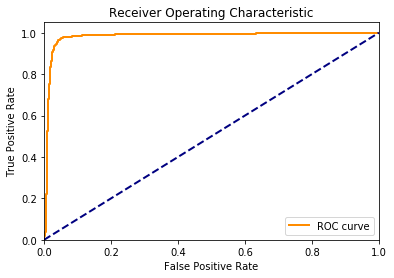

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = clf_fit.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_score)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [283]:
output = np.matmul(X_test, clf_fit.coef_.transpose()) + clf_fit.intercept_

# output
y_pred = [1. if y > 0 else 0. for y in output]
confusion_matrix(y_test, y_pred)


array([[ 518,   86],
       [  27, 2092]])

In [82]:
X_test[y_test != y_pred]

array([[ 0.2288828 ,  0.29578836, -0.44409819, ...,  0.56029224,
         0.7058806 , -0.91441104],
       [ 0.10984455,  0.11091298,  0.30138103, ..., -0.38246169,
        -0.42799784,  1.17240407],
       [-0.11244534,  0.03882391, -0.03287104, ...,  0.01650637,
         0.31327942,  0.24213709],
       ...,
       [ 2.8859408 , -0.82018898, -0.97122909, ...,  0.13900388,
         0.51852287,  0.99640762],
       [-0.13435914, -1.2772015 ,  0.28452834, ...,  0.10044697,
         2.19554359, -0.91441104],
       [-0.11864781, -0.94893283, -0.43682114, ...,  0.474871  ,
         1.89898956,  1.34840053]])

## KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=2)
print_evaluation_result(clf, X, y)


Scoring Metric: accuracy
---------
Scores: [0.93555094 0.95306001 0.74450386 0.90225787 0.8134284  0.99079026
 0.98306092 0.97830609 0.96968796 0.93224368]
accuracy: 0.92 (+/- 0.15)

Scoring Metric: balanced_accuracy
---------
Scores: [0.86117863 0.94550764 0.58807511 0.92430197 0.87568637 0.99039531
 0.97538675 0.98228678 0.96942977 0.94966351]
balanced_accuracy: 0.91 (+/- 0.23)

Scoring Metric: f1
---------
Scores: [0.95979248 0.96921278 0.84103512 0.93298024 0.86258206 0.99400271
 0.98901099 0.98576165 0.98011696 0.95425361]
f1: 0.95 (+/- 0.10)

Scoring Metric: f1_weighted
---------
Scores: [0.93172523 0.95358498 0.72800154 0.90689235 0.82738786 0.99082109
 0.98304935 0.9785712  0.97003994 0.93476487]
f1_weighted: 0.92 (+/- 0.16)

Scoring Metric: recall
---------
Scores: [0.99884304 0.95949074 0.87770062 0.88348765 0.76041667 0.99112654
 0.98958333 0.97492284 0.96990741 0.91743827]
recall: 0.93 (+/- 0.14)



## MLP (Multi-Layer Perceptron Classifier)

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1, max_iter=1000, activation='identity')
print_evaluation_result(clf, X, y)

Scoring Metric: accuracy
---------
Scores: [0.91476091 0.85650624 0.81313131 0.77599525 0.8134284  0.84076055
 0.87994056 0.9102526  0.9640416  0.94829123]
accuracy: 0.87 (+/- 0.12)

Scoring Metric: balanced_accuracy
---------
Scores: [0.82041344 0.69984119 0.63126705 0.7011601  0.82516419 0.68525248
 0.76592695 0.85756328 0.92667008 0.92142806]
balanced_accuracy: 0.78 (+/- 0.19)

Scoring Metric: f1
---------
Scores: [0.94999084 0.91683133 0.89569683 0.85110471 0.87238408 0.90666667
 0.92705882 0.94194541 0.9775921  0.96867192]
f1: 0.92 (+/- 0.08)

Scoring Metric: f1_weighted
---------
Scores: [0.90978817 0.82655824 0.78379084 0.75024021 0.83278398 0.82348531
 0.87823059 0.90119624 0.96611379 0.95333738]
f1_weighted: 0.86 (+/- 0.13)

Scoring Metric: recall
---------
Scores: [1.         0.98611111 0.97569444 0.85108025 0.82137346 0.98109568
 0.99421296 0.94058642 0.99074074 0.97646605]
recall: 0.95 (+/- 0.12)



In [14]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1, max_iter=1000, activation='relu')
print_evaluation_result(clf, X, y)

Scoring Metric: accuracy
---------
Scores: [0.91743392 0.9456328  0.78342246 0.8704694  0.85442662 0.92097445
 0.95482912 0.98008915 0.97325409 0.95185736]
accuracy: 0.92 (+/- 0.12)

Scoring Metric: balanced_accuracy
---------
Scores: [0.84476841 0.91238246 0.57947979 0.8520941  0.88432206 0.87781726
 0.90066061 0.96578611 0.9494454  0.93284442]
balanced_accuracy: 0.87 (+/- 0.21)

Scoring Metric: f1
---------
Scores: [0.94875549 0.96623672 0.87447699 0.91233701 0.89614984 0.94648829
 0.97301378 0.99043611 0.98294692 0.96968527]
f1: 0.95 (+/- 0.07)

Scoring Metric: f1_weighted
---------
Scores: [0.91197614 0.94752519 0.73954331 0.87027635 0.86446691 0.9081311
 0.95793684 0.98377696 0.97269465 0.94660077]
f1_weighted: 0.91 (+/- 0.14)

Scoring Metric: recall
---------
Scores: [0.99961435 0.9845679  0.95717593 0.87654321 0.85146605 0.98649691
 0.99382716 0.99884259 0.99151235 0.95486111]
recall: 0.96 (+/- 0.10)



In [15]:
clf_fit = clf.fit(X_train, y_train)

In [17]:
clf_fit.coefs_

[array([[ 0.0026518 , -0.00231123,  0.00114058, ..., -0.00399185,
         -0.00081557,  0.00824428],
        [-0.00832938,  0.01788781, -0.01624027, ...,  0.01053059,
          0.00798046, -0.01847192],
        [-0.04600135,  0.09737997, -0.0873595 , ...,  0.05899013,
          0.04375023, -0.12811422],
        ...,
        [ 0.02550574, -0.0544871 ,  0.04860669, ..., -0.03195088,
         -0.02417304,  0.08472809],
        [-0.00580312,  0.01221735, -0.01083614, ...,  0.00784044,
          0.00541839, -0.00982665],
        [ 0.01695234, -0.03581913,  0.03237605, ..., -0.02166509,
         -0.01633526,  0.04975283]]), array([[ 0.08930643],
        [-0.19063661],
        [ 0.17105821],
        [ 0.35061924],
        [-0.15358283],
        [-0.28293363],
        [-0.14207488],
        [-0.16524062],
        [ 0.06991162],
        [ 0.25258654],
        [-0.28449418],
        [-0.10599163],
        [ 0.27649007],
        [-0.15969964],
        [ 0.28904187],
        [-0.11454038],
      

In [18]:
clf_fit.intercepts_

[array([ 0.11563697,  0.12901277, -0.34700671, -0.22364646, -0.02973561,
         0.28050259,  0.41449398, -0.10426473,  0.0560841 , -0.25752185,
         0.34337259,  0.39330833, -0.02653838,  0.11686973, -0.12748676,
         0.17552365,  0.11804824, -0.1387047 , -0.34171726, -0.26604545,
        -0.02316204, -0.05438318, -0.14961552,  0.03181377, -0.28284224,
        -0.33471685, -0.15572433, -0.29919853,  0.10481938,  0.14340936,
        -0.03529199,  0.01382562,  0.12517701, -0.08208568,  0.10748344,
        -0.35508674,  0.0883365 , -0.13691085, -0.20878271, -0.28455325,
        -0.28009243, -0.32070472, -0.33721886,  0.09056198,  0.34432453,
        -0.11553047, -0.35892953,  0.04018979,  0.22368239, -0.23009333,
        -0.09608021,  0.3298748 ,  0.12245127,  0.16132106, -0.14907171,
        -0.17775471, -0.16044844, -0.31117275, -0.17447362, -0.05452529,
        -0.13816476, -0.3234145 , -0.10343409, -0.05255129,  0.39884727,
        -0.07781698, -0.36233351, -0.25529562, -0.1

In [164]:
y_pred = clf_fit.predict(X_test)
# y_pred
confusion_matrix(y_test, y_pred)

array([[2515,   22],
       [  46,  305]])

In [166]:
output = np.matmul(np.matmul(X_test, clf_fit.coefs_[0]) + clf_fit.intercepts_[0], clf_fit.coefs_[1]) + clf_fit.intercepts_[1]
# y_pred = 1 / (1 + np.exp(-output))

# output
y_pred = [1. if y > 0 else 0. for y in output]
confusion_matrix(y_test, y_pred)


array([[2515,   22],
       [  46,  305]])

In [135]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, clf_fit.predict_proba(X_test)[:,1])

In [141]:
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [134]:
print(list(zip(y_pred, y_train)))

[(0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (1, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (1, 1.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (1, 1.0), (0, 0.0), (0, 0.0), (0, 0.0),

In [115]:
clf_fit.intercepts_

[array([ 0.09817909,  0.14022423, -0.2710823 ,  0.14658454,  0.31303232,
         0.22022538, -0.17757525, -0.0150899 , -0.12645556, -0.15709481,
         0.03103255,  0.18684006, -0.28118006, -0.34409314, -0.19932179,
         0.31360177, -0.09771656,  0.06530222,  0.03205704,  0.29763413,
         0.169806  , -0.0841407 ,  0.16715694,  0.32389112, -0.24196104,
         0.31818908, -0.06837678,  0.15088643, -0.10969794,  0.17988545,
         0.32977771, -0.23672955,  0.2735609 ,  0.19377495,  0.05513764,
        -0.06925192,  0.14325775, -0.18872785,  0.10891123, -0.16790059,
        -0.12280929, -0.27533466,  0.33470772,  0.05615536, -0.19758793,
         0.269677  ,  0.22308008,  0.13898509, -0.03674593,  0.13068361,
         0.22863965,  0.10038282,  0.10158403,  0.10108947, -0.17800446,
        -0.16808938, -0.29673094,  0.1804681 ,  0.3823297 , -0.2022905 ,
        -0.10864011, -0.24046087,  0.21374284, -0.00343896,  0.28684868,
        -0.12803908, -0.08828574, -0.20702357,  0.2

In [112]:
print_evaluation_result(clf, X, y)

Scoring Metric: accuracy
---------
Scores: [0.97648686 0.97372061 0.98060942 0.98060942 0.97645429 0.98891967
 0.97229917 0.97087379 0.94729542 0.91678225]
accuracy: 0.97 (+/- 0.04)

Scoring Metric: balanced_accuracy
---------
Scores: [0.90217391 0.9076087  0.92307692 0.92307692 0.92857143 0.95604396
 0.91362045 0.92222222 0.85860806 0.853663  ]
balanced_accuracy: 0.91 (+/- 0.06)

Scoring Metric: f1
---------
Scores: [0.88484848 0.88484848 0.92307692 0.91666667 0.87654321 0.95402299
 0.88636364 0.88135593 0.76646707 0.69306931]
f1: 0.87 (+/- 0.15)

Scoring Metric: f1_weighted
---------
Scores: [0.97240244 0.97544635 0.98139373 0.98139373 0.97691007 0.98869985
 0.97174961 0.97051996 0.95036575 0.91992402]
f1_weighted: 0.97 (+/- 0.04)

